# Réalisation de la table Fitness (1 mi-temps, 1 joueur)

In [3]:
from fonctions_perso import sql_request
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

ms_kmh = 60*60/1000
sec_min = 1/60

slt gro


## Aide mémoire

Liste des variables de la table tracking : 
- time_sec
- ht
- posx
- posy
- name_id
- team_id
- date_id
- match_id

Liste des joueurs du match considéré :

In [138]:
str(list(sql_request("SELECT DISTINCT name_id FROM tracking WHERE match_id LIKE 'Match_001'").name_id))

"['Player_0004', 'Player_0005', 'Player_0010', 'Player_0021', 'Player_0025', 'Player_0029', 'Player_0030', 'Player_0032', 'Player_0034', 'Player_0035', 'Player_0036', 'Player_0040', 'Player_0044', 'Player_0047', 'Player_0056', 'Player_0060', 'Player_0061', 'Player_0063', 'Player_0067', 'Player_0070', 'Player_0073', 'Player_0079', 'Player_0083', 'Player_0085', 'Player_0087', 'Player_0088', 'Player_0090', 'Player_0092']"

## 1) Vitesse et accélération d'un joueur

###  1.1) Gestion de la base de données

Dans un premier temps, il faut récupérer les données pour un joueur et un mi-temps d'un match (si on prend deux mi-temps il faut mettre des NaN à la reprise). Il faut également réduire le nombre d'obervation en prenant une position toutes les secondes. Il s'agira ensuite de calculer les données de vitesse et d'accélération puis de faire des statistiques dessus.

De base, les distances sont en centimètre. Le temps est en seconde (avec une track toute les 0.1 sec). Nous allons mettre les vitesses en m/s et les accélérations en m/s².

In [4]:
def build_fitness(j,m,ht,t):
    retour = sql_request("SELECT * FROM tracking WHERE match_id LIKE '"+m+"' AND name_id LIKE '"+j+"' AND ht = "+ht+" AND time_sec < "+t)
    #retour = retour.iloc[list(range(0,len(retour),10))] filtrage
    
    #Les positions sont en cm au départ. Il convient de les mettre en m (x0.01)
    #L'intervalle de temps est de 0.1 sec. 
    #Le coeff. multiplicatif est de 0.1 pour les vitesses
    retour['vitx']=retour.posx.diff()*0.1
    retour['vity']=retour.posy.diff()*0.1
    retour['accx']=retour.vitx.diff()/0.1
    retour['accy']=retour.vity.diff()/0.1
    
    retour['vit_abs']=np.sqrt(retour.vitx**2 + retour.vity**2)
    retour['acc']=retour.vit_abs.diff()/0.1
        
    acc_beginning=(retour.acc>2).astype(np.float32).cumsum()
    acc_ending=(retour.acc<2).astype(np.float32).cumsum()  
    retour['acc_id']=None
    retour['acc_id'][acc_beginning==acc_ending]=0
    retour['acc_id'][acc_beginning!=acc_ending]=acc_beginning[acc_beginning!=acc_ending]
    
    course_beginning=(retour.vit_abs*ms_kmh>25).astype(np.float32).cumsum()
    course_ending=(retour.vit_abs*ms_kmh<25).astype(np.float32).cumsum()  
    retour['course_id']=None
    retour['course_id'][course_beginning==course_ending]=0
    retour['course_id'][course_beginning!=course_ending]=course_beginning[course_beginning!=course_ending]
    
    return retour

In [153]:
print(build_fitness("Player_0004","Match_001","2","200")[:5])

   time_sec ht  posx  posy      name_id  team_id   date_id   match_id  vitx  \
0       0.0  2   -34 -2100  Player_0004  Team_02  Date_001  Match_001   NaN   
1       0.1  2   -24 -2110  Player_0004  Team_02  Date_001  Match_001   1.0   
2       0.2  2   -14 -2122  Player_0004  Team_02  Date_001  Match_001   1.0   
3       0.3  2    -4 -2134  Player_0004  Team_02  Date_001  Match_001   1.0   
4       0.4  2     7 -2147  Player_0004  Team_02  Date_001  Match_001   1.1   

   vity  accx  accy   vit_abs       acc acc_id course_id  
0   NaN   NaN   NaN       NaN       NaN      0         0  
1  -1.0   NaN   NaN  1.414214       NaN      0         0  
2  -1.2   0.0  -2.0  1.562050  1.478364      0         0  
3  -1.2   0.0   0.0  1.562050  0.000000      0         0  
4  -1.3   1.0  -1.0  1.702939  1.408887      0         0  


/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying

### 1.2) Statistique exploratoire sur les vitesses et accélérations

In [5]:
joueur1=build_fitness("Player_0021","Match_001","1",str(45*60))

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying

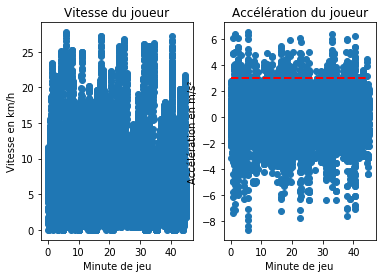

In [90]:
plt.subplot(1,2,1)
plt.scatter(joueur1.time_sec*sec_min,joueur1.vit_abs.fillna(0.)*ms_kmh)
plt.ylabel('Vitesse en km/h')
plt.xlabel('Minute de jeu')
plt.title('Vitesse du joueur')

plt.subplot(1,2,2)
plt.scatter(joueur1.time_sec*sec_min,joueur1.acc.fillna(0.))
plt.ylabel('Accélération en m/s²')
plt.xlabel('Minute de jeu')
plt.title('Accélération du joueur')
plt.plot([0.0, 45.0], [3.0, 3.0], 'r--', lw=2) # Blue dashed straight line
plt.show()

In [154]:
joueur1=build_fitness("Player_0005","Match_001","2",str(60*45))

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying

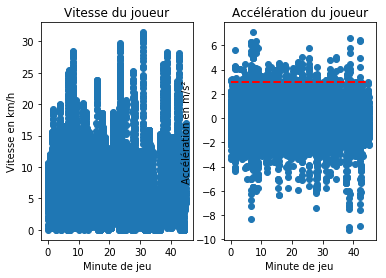

In [155]:
plt.subplot(1,2,1)
plt.scatter(joueur1.time_sec*sec_min,joueur1.vit_abs.fillna(0.)*ms_kmh)
plt.ylabel('Vitesse en km/h')
plt.xlabel('Minute de jeu')
plt.title('Vitesse du joueur')

plt.subplot(1,2,2)
plt.scatter(joueur1.time_sec*sec_min,joueur1.acc.fillna(0.))
plt.ylabel('Accélération en m/s²')
plt.xlabel('Minute de jeu')
plt.title('Accélération du joueur')
plt.plot([0.0, 45.0], [3.0, 3.0], 'r--', lw=2)
plt.show()

## 2) Etude du temps passé en forte accélération

- Nombre d'accélérations > 3 ms-2 de plus d'1 sec
- Durée médiane des accélérations > 3ms-2 de plus d'1 sec
- Durée max des accélérations > 3ms-2 de plus d'1 sec
- Distance totale au cours d'accélérations > 3 ms-2 de plus d'1 sec

In [7]:
def stat_acc(fitness):
    pic_acc = fitness.groupby('acc_id')['acc'].max()
    duree   = fitness.groupby('acc_id')['time_sec'].max() - fitness.groupby('acc_id')['time_sec'].min()
    # Calcul de la distance valable que parce que "intervalle de temps régulier"
    dist    = fitness.groupby('acc_id')['vit_abs'].sum() * 0.1
    
    retour = pd.concat([pic_acc,duree,dist], axis=1)
    retour.columns = ['pic_acc','duree',"dist"]
    return retour[retour.index>0][retour.pic_acc>=3][retour.duree>1]

statacc = stat_acc(joueur1)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [129]:
print("Nombre d'accélération dépassant les 3m/s² : "+str(len(statacc)))
print("Durée médiane des accélérations : "+str(np.median(statacc.duree))+" sec")
print("Durée maximale des accélérations : "+str(max(statacc.duree))+" sec")
print("Distance totale : "+str(sum(statacc.dist))+" m")

Nombre d'accélération dépassant les 3m/s² : 25
Durée médiane des accélérations : 4.5 sec
Durée maximale des accélérations : 41.30000000000001 sec
Distance totale : 444.08008819355547 m


## 3) Etude du temps passé à plus de 25km/h

- Nombre de courses où vitesse >= 25 km/h pendant plus d'1 sec
- Durée médiane où vitesse >= 25 km/h pendant plus d'1 sec
- Durée max où vitesse >= 25 km/h pendant plus d'1 sec
- Distance totale où vitesse >= 25 km/h pendant plus d'1 sec

In [133]:
def stat_course(fitness):
    pic_vit = fitness.groupby('course_id')['vit_abs'].max() * ms_kmh
    duree   = fitness.groupby('course_id')['time_sec'].max() - fitness.groupby('course_id')['time_sec'].min()
    # Calcul de la distance valable que parce que "intervalle de temps régulier"
    dist    = fitness.groupby('course_id')['vit_abs'].sum() * 0.1
    
    retour = pd.concat([pic_vit,duree,dist], axis=1)
    retour.columns = ['pic_vit','duree',"dist"]
    return retour[retour.index>0][retour.duree >= 1]

statcourse = stat_course(joueur1)

/home/ec2-user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [135]:
print("Nombre de courses dépassant les 25km/h : "+str(len(statcourse)))
print("Durée médiane des courses : "+str(np.median(statcourse.duree))+" sec")
print("Durée maximale des accélérations : "+str(max(statcourse.duree))+" sec")
print("Distance totale : "+str(sum(statcourse.dist))+" m")

Nombre de courses dépassant les 25km/h : 12
Durée médiane des courses : 156.1 sec
Durée maximale des accélérations : 391.5 sec
Distance totale : 4326.127860116465 m


## 4) Statistique globale sur la mi-temps

- Distance totale parcourue
- Nombre de minutes jouées

In [152]:
print("Distance : "+str(sum(joueur1.vit_abs.fillna(0.))*0.1))
print("Durée jouée : "+str((max(joueur1.time_sec)-min(joueur1.time_sec))/60))

Distance : 5064.631237614457
Durée jouée : 44.998333333333335
